### 主代码

In [1]:
# from langchain_community.chat_models import ChatOllama
# from langchain_core.prompts import SystemMessagePromptTemplate,HumanMessagePromptTemplate,AIMessagePromptTemplate
# from langchain_core.messages import (
#     SystemMessage,
#     AIMessage,
#     HumanMessage
# )
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import Ollama

In [2]:
import os
import numpy as np
import pandas as pd
import time
import argparse
import json
from tqdm import tqdm 

In [3]:
choices = ["A", "B", "C", "D"]  # 数据集结构是四选一

In [4]:
def format_subject(subject):
    "转化为无特殊字符格式"
    l = subject.split("_")
    s = ""
    for entry in l:
        s += " " + entry
    return s

In [5]:
def format_example(df, idx, include_answer=True):
    # 格式化选项内容
    prompt = df.iloc[idx, 0] # 问题
    k = df.shape[1] - 2   # 4个选项
    for j in range(k):
        prompt += "\n{}. {}".format(choices[j], df.iloc[idx, j+1])
    prompt += "\nAnswer(must choose only one from [A,B,C,D], don't say anything else):"
    if include_answer:
        prompt += " {}\n\n".format(df.iloc[idx, k + 1])
    return prompt

In [6]:
def gen_prompt(train_df, subject, k=-1):
    prompt = "The following are multiple choice questions (with answers) about {}.\n\n".format(format_subject(subject))
    if k == -1:
        k = train_df.shape[0]  # 毕竟不知道训练集中每个科目的条目数
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt

In [7]:
def eval(args, subject, engine, dev_df, test_df):
    """
    对当前subject利用model进行评测
    """
    model = Ollama(model = engine+":7b",
                  temperature=0,
                  num_predict=1,
                  top_k=1)
    cors = []  # 正确率
#     all_probs = []  # 各选项概率
    answers = choices[:test_df.shape[1]-2]  # 四个选项
    print(answers)
    print(f"subject: {subject}")
    for i in tqdm(range(test_df.shape[0]), desc="Generating"):  # 原来为 
        # get prompt and make sure it fits 利用few_shots进行产生prompt
        k = args.ntrain   # 每个学科的测试数据集只有ntrain个条目，即5shots
        prompt_end = format_example(test_df, i, include_answer=False)   # 这个是要模型回答的，不要答案
        train_prompt = gen_prompt(dev_df, subject, k)  # ntrain_shots
        prompt = train_prompt + prompt_end # 构成完整prompt

#         while crop(prompt) != prompt:   # 防止一些shot不足情况
#             k -= 1
#             train_prompt = gen_prompt(dev_df, subject, k)
#             prompt = train_prompt + prompt_end

        label = test_df.iloc[i, test_df.shape[1]-1]  # 问题i的标注答案
 
        while True:
            try:
                response = model.invoke(prompt)
#                 print(response)
                break
                # 必须检验生成的是否是四个选项之一
#                 if response in answers:
#                     break
#                 else:
#                     print(response)
#                     prompt = "forget the memory before, and " + prompt
#                     continue
            except Exception as e:
                print("pausing")
                print(f"ERROR Occuring: {e}")
                time.sleep(2)
                continue

#         lprobs = []
        pred = response
#         probs = softmax(np.array(lprobs))

        cor = pred == label  # 是否回答正确
        cors.append(cor)
#         all_probs.append(probs)

    acc = np.mean(cors)  # 本学科上的回答正确率
    cors = np.array(cors)  # 正确回答的题号对应

#     all_probs = np.array(all_probs)  # 每题回答正确的概率
    print("Average accuracy {:.3f} - {}".format(acc, subject))
    
    result_df = [{
        "subject": subject,
        "acc": acc,
    }]
    result_df = pd.DataFrame(result_df)
    
    csv_file_path = os.path.join(args.save_dir, f"{engine}_results", f'{engine}_subjects_total_eval_results.csv')
    
    if not os.path.exists(csv_file_path):
        result_df.to_csv(csv_file_path, header=None, index=None)  # 创建文件并写入
    else:
        result_df.to_csv(csv_file_path, mode='a', header=None, index=None) # 数据追加
        

    return cors, acc

In [8]:
def main(info):
    models = info.models
#     print(models)
    subjects = [f.split("_test.csv")[0] for f in os.listdir(os.path.join(info.data_dir, "test"))]
   # 保存结果文件夹创建 
    if not os.path.exists(info.save_dir):
        os.mkdir(info.save_dir)
    
    for model in models:
        if not os.path.exists(os.path.join(info.save_dir, f"{model}_results")):
            os.mkdir(os.path.join(info.save_dir, f"{model}_results"))
    
    # 对每个模型进行评估
    for model in tqdm(models, desc="模型评测"):
        eval_cors = []  # 模型对所有学科的评测
        print(f"{model} is on Evoluation.")
        
        for subject in tqdm(subjects, desc="subjects"): # 删掉[:3]    # 自从第32个subject后每个都只回答20个吧，跑了两天了，受不了了
            # 开发集
            dev_df = pd.read_csv(os.path.join(info.data_dir, "dev", subject + "_dev.csv"), header=None)[:info.ntrain]
            # 测试集
            test_df = pd.read_csv(os.path.join(info.data_dir, "test", subject + "_test.csv"), header=None)
            # 进行评测
            cors, acc = eval(info, subject, model, dev_df, test_df)
            eval_cors.append(cors)  # 本次学科评测
#             temp_df = test_df[:20]
#             temp_df["{}_ans_correct".format(model)] = cors
            test_df["{}_ans_correct".format(model)] = cors  ##本与下行恢复，上两行删除
            test_df.to_csv(os.path.join(info.save_dir, f"{model}_results", "{}.csv".format(subject)), header=None, index=None)
#             temp_df.to_csv(os.path.join(info.save_dir, f"{model}_results", "{}.csv".format(subject)), header=None, index=None)
        
        weighted_acc = np.mean(np.concatenate(eval_cors)) # 在所有学科上的正确率
        print("**"*20)
        print(f"Average accuracy: {weighted_acc:.3f}")

        
            

In [9]:
class My_Info:
    def __init__(self,
                ntrain:int = 5,  # 开发集实例数量
                data_dir:str = "data",
                save_dir:str = "results",
                models:list = ["qwen"]):
        self.ntrain = ntrain
        self.data_dir = data_dir
        self.save_dir = save_dir
        self.models = models
info = My_Info()

In [10]:
main(info)

模型评测:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

qwen is on Evoluation.



subjects:   0%|                                                                                 | 0/26 [00:00<?, ?it/s]

['A', 'B', 'C', 'D']
subject: high_school_world_history




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [01:06<20:57, 66.18s/it]

Generating:  10%|███████                                                                | 2/20 [01:21<10:49, 36.09s/it]

Generating:  15%|██████████▋                                                            | 3/20 [01:41<08:09, 28.78s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [01:52<05:47, 21.73s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [02:08<04:54, 19.64s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [02:24<04:21, 18.69s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [02:41<03:54, 18.07s/it]

Generating:  40%|█████████████

Average accuracy 0.700 - high_school_world_history
['A', 'B', 'C', 'D']
subject: human_aging




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:18<05:43, 18.08s/it]

Generating:  10%|███████                                                                | 2/20 [00:24<03:26, 11.49s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:31<02:38,  9.33s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:34<01:51,  6.94s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:41<01:42,  6.87s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:48<01:34,  6.78s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [00:55<01:27,  6.76s/it]

Generating:  40%|█████████████

Average accuracy 0.600 - human_aging
['A', 'B', 'C', 'D']
subject: human_sexuality




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:18<05:45, 18.17s/it]

Generating:  10%|███████                                                                | 2/20 [00:24<03:25, 11.41s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:31<02:37,  9.24s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:38<02:12,  8.28s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:44<01:55,  7.69s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:51<01:42,  7.32s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [00:58<01:32,  7.11s/it]

Generating:  40%|█████████████

Average accuracy 0.750 - human_sexuality
['A', 'B', 'C', 'D']
subject: international_law




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:26<08:23, 26.48s/it]

Generating:  10%|███████                                                                | 2/20 [00:33<04:29, 14.95s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:40<03:11, 11.24s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:50<02:51, 10.71s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:56<02:19,  9.30s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:06<02:12,  9.49s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:13<01:51,  8.61s/it]

Generating:  40%|█████████████

Average accuracy 0.650 - international_law
['A', 'B', 'C', 'D']
subject: jurisprudence




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:19<06:18, 19.95s/it]

Generating:  10%|███████                                                                | 2/20 [00:26<03:41, 12.29s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:33<02:46,  9.80s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:40<02:18,  8.67s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:47<02:01,  8.09s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:54<01:47,  7.65s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:01<01:37,  7.47s/it]

Generating:  40%|█████████████

Average accuracy 0.750 - jurisprudence
['A', 'B', 'C', 'D']
subject: logical_fallacies




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:19<06:10, 19.48s/it]

Generating:  10%|███████                                                                | 2/20 [00:26<03:37, 12.09s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:33<02:46,  9.80s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:40<02:19,  8.73s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:47<02:01,  8.08s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:54<01:47,  7.69s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:01<01:36,  7.46s/it]

Generating:  40%|█████████████

Average accuracy 0.650 - logical_fallacies
['A', 'B', 'C', 'D']
subject: machine_learning




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:31<09:52, 31.19s/it]

Generating:  10%|███████                                                                | 2/20 [00:38<05:04, 16.89s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:45<03:30, 12.41s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:52<02:45, 10.33s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:59<02:17,  9.14s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:06<01:57,  8.41s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:13<01:43,  7.93s/it]

Generating:  40%|█████████████

Average accuracy 0.350 - machine_learning
['A', 'B', 'C', 'D']
subject: management




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:18<05:51, 18.49s/it]

Generating:  10%|███████                                                                | 2/20 [00:25<03:27, 11.55s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:31<02:39,  9.38s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:38<02:13,  8.37s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:45<01:57,  7.81s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:48<01:28,  6.29s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [00:55<01:23,  6.44s/it]

Generating:  40%|█████████████

Average accuracy 0.750 - management
['A', 'B', 'C', 'D']
subject: marketing




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:23<07:26, 23.49s/it]

Generating:  10%|███████                                                                | 2/20 [00:30<04:05, 13.67s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:37<02:59, 10.54s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:43<02:25,  9.09s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:53<02:19,  9.27s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:00<01:57,  8.42s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:07<01:42,  7.89s/it]

Generating:  40%|█████████████

Average accuracy 0.750 - marketing
['A', 'B', 'C', 'D']
subject: medical_genetics




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:18<05:57, 18.81s/it]

Generating:  10%|███████                                                                | 2/20 [00:25<03:31, 11.77s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:32<02:43,  9.61s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:39<02:16,  8.54s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:46<01:59,  7.97s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:53<01:46,  7.62s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:00<01:35,  7.35s/it]

Generating:  40%|█████████████

Average accuracy 0.700 - medical_genetics
['A', 'B', 'C', 'D']
subject: miscellaneous




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:18<05:51, 18.51s/it]

Generating:  10%|███████                                                                | 2/20 [00:25<03:31, 11.74s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:32<02:41,  9.50s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:39<02:15,  8.47s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:46<01:59,  7.96s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:53<01:46,  7.64s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [00:56<01:20,  6.22s/it]

Generating:  40%|█████████████

Average accuracy 0.650 - miscellaneous
['A', 'B', 'C', 'D']
subject: moral_disputes




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:23<07:30, 23.73s/it]

Generating:  10%|███████                                                                | 2/20 [00:30<04:09, 13.84s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:40<03:22, 11.90s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:47<02:39,  9.98s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:54<02:12,  8.84s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:00<01:53,  8.13s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:07<01:41,  7.79s/it]

Generating:  40%|█████████████

Average accuracy 0.450 - moral_disputes
['A', 'B', 'C', 'D']
subject: moral_scenarios




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:31<10:02, 31.72s/it]

Generating:  10%|███████                                                                | 2/20 [00:38<05:07, 17.10s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:45<03:32, 12.48s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:52<02:44, 10.30s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:59<02:16,  9.09s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:06<01:57,  8.38s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:13<01:42,  7.91s/it]

Generating:  40%|█████████████

Average accuracy 0.400 - moral_scenarios
['A', 'B', 'C', 'D']
subject: nutrition




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:27<08:38, 27.30s/it]

Generating:  10%|███████                                                                | 2/20 [00:34<04:37, 15.40s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:41<03:16, 11.57s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:48<02:36,  9.77s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:55<02:11,  8.76s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:02<01:53,  8.11s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:09<01:40,  7.75s/it]

Generating:  40%|█████████████

Average accuracy 0.700 - nutrition
['A', 'B', 'C', 'D']
subject: philosophy




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:18<05:55, 18.69s/it]

Generating:  10%|███████                                                                | 2/20 [00:25<03:31, 11.74s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:32<02:40,  9.47s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:39<02:14,  8.39s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:46<01:59,  8.00s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:53<01:46,  7.63s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:00<01:35,  7.37s/it]

Generating:  40%|█████████████

Average accuracy 0.700 - philosophy
['A', 'B', 'C', 'D']
subject: prehistory




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:26<08:17, 26.18s/it]

Generating:  10%|███████                                                                | 2/20 [00:33<04:27, 14.85s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:40<03:12, 11.30s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:47<02:33,  9.60s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:53<02:08,  8.60s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:00<01:52,  8.02s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:07<01:39,  7.68s/it]

Generating:  40%|█████████████

Average accuracy 0.600 - prehistory
['A', 'B', 'C', 'D']
subject: professional_accounting




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:35<11:17, 35.65s/it]

Generating:  10%|███████                                                                | 2/20 [00:42<05:38, 18.80s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:52<04:12, 14.84s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:59<03:07, 11.71s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [01:06<02:29,  9.99s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:13<02:05,  8.95s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:23<02:00,  9.23s/it]

Generating:  40%|█████████████

Average accuracy 0.250 - professional_accounting
['A', 'B', 'C', 'D']
subject: professional_law




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [01:06<21:01, 66.42s/it]

Generating:  10%|███████                                                                | 2/20 [01:22<11:01, 36.73s/it]

Generating:  15%|██████████▋                                                            | 3/20 [01:33<07:08, 25.18s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [01:45<05:14, 19.68s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [01:56<04:09, 16.64s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [02:03<03:08, 13.44s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [02:19<03:05, 14.26s/it]

Generating:  40%|█████████████

Average accuracy 0.200 - professional_law
['A', 'B', 'C', 'D']
subject: professional_medicine




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:48<15:27, 48.82s/it]

Generating:  10%|███████                                                                | 2/20 [01:00<08:00, 26.68s/it]

Generating:  15%|██████████▋                                                            | 3/20 [01:11<05:34, 19.68s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [01:27<04:52, 18.26s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [01:39<03:58, 15.92s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:49<03:16, 14.01s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [02:05<03:11, 14.77s/it]

Generating:  40%|█████████████

Average accuracy 0.500 - professional_medicine
['A', 'B', 'C', 'D']
subject: professional_psychology




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:28<09:07, 28.82s/it]

Generating:  10%|███████                                                                | 2/20 [00:36<04:50, 16.15s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:46<03:52, 13.68s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:54<02:57, 11.12s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [01:01<02:25,  9.72s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:08<02:04,  8.90s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:15<01:49,  8.39s/it]

Generating:  40%|█████████████

Average accuracy 0.550 - professional_psychology
['A', 'B', 'C', 'D']
subject: public_relations




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:24<07:54, 24.99s/it]

Generating:  10%|███████                                                                | 2/20 [00:36<05:05, 16.98s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:43<03:32, 12.50s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:50<02:46, 10.42s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:57<02:18,  9.25s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:05<02:00,  8.58s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:12<01:45,  8.13s/it]

Generating:  40%|█████████████

Average accuracy 0.450 - public_relations
['A', 'B', 'C', 'D']
subject: security_studies




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:47<14:53, 47.03s/it]

Generating:  10%|███████                                                                | 2/20 [00:58<07:50, 26.13s/it]

Generating:  15%|██████████▋                                                            | 3/20 [01:14<06:06, 21.57s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [01:22<04:15, 15.96s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [01:38<04:01, 16.11s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:50<03:24, 14.59s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [02:00<02:51, 13.22s/it]

Generating:  40%|█████████████

Average accuracy 0.350 - security_studies
['A', 'B', 'C', 'D']
subject: sociology




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:20<06:38, 20.98s/it]

Generating:  10%|███████                                                                | 2/20 [00:28<03:52, 12.94s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:35<02:56, 10.36s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:42<02:25,  9.12s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:50<02:06,  8.44s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:57<01:52,  8.02s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:04<01:41,  7.77s/it]

Generating:  40%|█████████████

Average accuracy 0.550 - sociology
['A', 'B', 'C', 'D']
subject: us_foreign_policy




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:24<07:49, 24.72s/it]

Generating:  10%|███████                                                                | 2/20 [00:31<04:19, 14.43s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:39<03:08, 11.10s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:46<02:33,  9.60s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:53<02:11,  8.75s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [01:00<01:55,  8.24s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:08<01:42,  7.91s/it]

Generating:  40%|█████████████

Average accuracy 0.850 - us_foreign_policy
['A', 'B', 'C', 'D']
subject: virology




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:19<06:15, 19.75s/it]

Generating:  10%|███████                                                                | 2/20 [00:26<03:42, 12.37s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:34<02:49,  9.96s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:41<02:21,  8.87s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:48<02:04,  8.30s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:55<01:51,  7.93s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [01:02<01:40,  7.70s/it]

Generating:  40%|█████████████

Average accuracy 0.400 - virology
['A', 'B', 'C', 'D']
subject: world_religions




Generating:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

Generating:   5%|███▌                                                                   | 1/20 [00:15<04:58, 15.70s/it]

Generating:  10%|███████                                                                | 2/20 [00:22<03:12, 10.68s/it]

Generating:  15%|██████████▋                                                            | 3/20 [00:30<02:34,  9.10s/it]

Generating:  20%|██████████████▏                                                        | 4/20 [00:37<02:13,  8.34s/it]

Generating:  25%|█████████████████▊                                                     | 5/20 [00:44<01:59,  7.94s/it]

Generating:  30%|█████████████████████▎                                                 | 6/20 [00:51<01:47,  7.71s/it]

Generating:  35%|████████████████████████▊                                              | 7/20 [00:58<01:37,  7.52s/it]

Generating:  40%|█████████████

Average accuracy 0.950 - world_religions
****************************************
Average accuracy: {weighted_acc:.3f}


In [13]:
model_result = pd.read_csv(os.path.join(info.save_dir, f"{info.models[0]}_results", f"{info.models[0]}_subjects_total_eval_results.csv"), header=None)

In [18]:
model_result.columns = ["subjects", "acc"]

In [19]:
model_result

,subjects,acc
0,abstract_algebra,0.390000
1,anatomy,0.459259
2,astronomy,0.565789
3,business_ethics,0.500000
4,clinical_knowledge,0.600000
5,college_biology,0.569444
6,college_chemistry,0.390000
7,college_computer_science,0.360000
8,college_mathematics,0.250000
9,college_medicine,0.526012


In [23]:
result_lis_dic = model_result.to_dict(orient="records")

In [24]:
sorted_result = sorted(result_lis_dic, key=lambda x: x['acc'], reverse=True)

In [25]:
sorted_result

[{'subjects': 'world_religions', 'acc': 0.95},
 {'subjects': 'us_foreign_policy', 'acc': 0.85},
 {'subjects': 'high_school_government_and_politics',
  'acc': 0.7512953367875648},
 {'subjects': 'human_sexuality', 'acc': 0.75},
 {'subjects': 'jurisprudence', 'acc': 0.75},
 {'subjects': 'management', 'acc': 0.75},
 {'subjects': 'marketing', 'acc': 0.75},
 {'subjects': 'high_school_psychology', 'acc': 0.7376146788990826},
 {'subjects': 'high_school_world_history', 'acc': 0.7},
 {'subjects': 'medical_genetics', 'acc': 0.7},
 {'subjects': 'nutrition', 'acc': 0.7},
 {'subjects': 'philosophy', 'acc': 0.7},
 {'subjects': 'computer_security', 'acc': 0.69},
 {'subjects': 'high_school_geography', 'acc': 0.6818181818181818},
 {'subjects': 'high_school_european_history', 'acc': 0.6606060606060606},
 {'subjects': 'international_law', 'acc': 0.65},
 {'subjects': 'logical_fallacies', 'acc': 0.65},
 {'subjects': 'miscellaneous', 'acc': 0.65},
 {'subjects': 'high_school_us_history', 'acc': 0.602941176470

C:\Users\20931\AppData\Local\Temp\ipykernel_25456\412675397.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


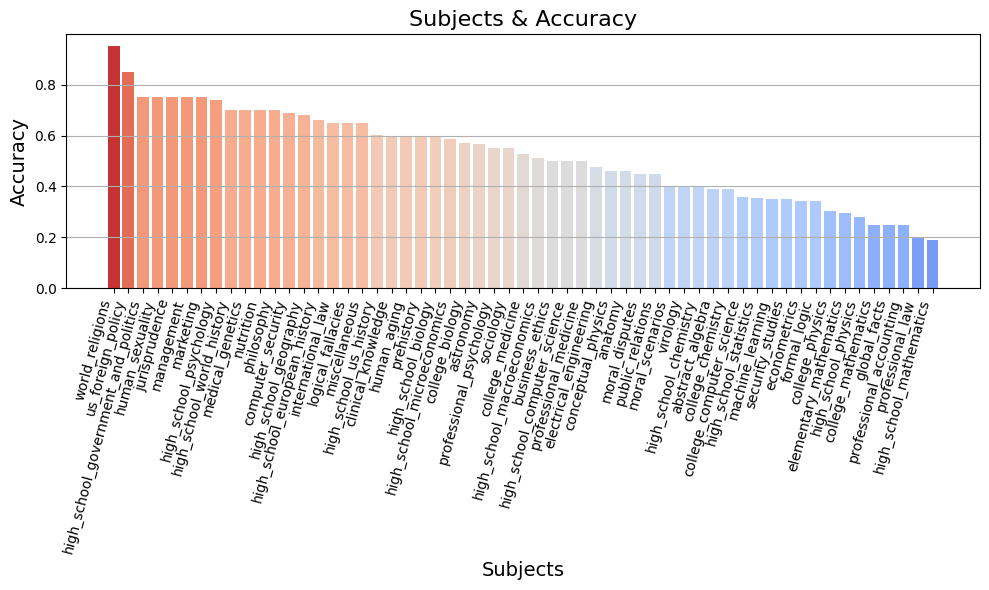

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 提取横坐标和纵坐标
subjects_lis = [item['subjects'] for item in sorted_result]
acc_lis = [item['acc'] for item in sorted_result]

# 创建颜色映射
cmap = cm.get_cmap('coolwarm')
bar_colors = [cmap(acc) for acc in acc_lis]

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(subjects_lis, acc_lis, color=bar_colors)

# 添加标题和标签
plt.title('Subjects & Accuracy', fontsize=16)
plt.xlabel('Subjects', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=75, ha='right')
# 显示网格
plt.grid(axis='y')

# 显示图形
plt.tight_layout()
plt.show()

In [33]:
# 计算数据集上的总体Acc
subject_eval_result_dir = os.listdir(os.path.join(info.save_dir, f"{info.models[0]}_results"))

In [37]:
# 筛选 

subject_eval_result_dir = [sub_result for sub_result in subject_eval_result_dir if ".csv" in sub_result]
subject_eval_result_dir.remove(f"{info.models[0]}_subjects_total_eval_results.csv")

In [38]:
subject_eval_result_dir

['abstract_algebra.csv',
 'anatomy.csv',
 'astronomy.csv',
 'business_ethics.csv',
 'clinical_knowledge.csv',
 'college_biology.csv',
 'college_chemistry.csv',
 'college_computer_science.csv',
 'college_mathematics.csv',
 'college_medicine.csv',
 'college_physics.csv',
 'computer_security.csv',
 'conceptual_physics.csv',
 'econometrics.csv',
 'electrical_engineering.csv',
 'elementary_mathematics.csv',
 'formal_logic.csv',
 'global_facts.csv',
 'high_school_biology.csv',
 'high_school_chemistry.csv',
 'high_school_computer_science.csv',
 'high_school_european_history.csv',
 'high_school_geography.csv',
 'high_school_government_and_politics.csv',
 'high_school_macroeconomics.csv',
 'high_school_mathematics.csv',
 'high_school_microeconomics.csv',
 'high_school_physics.csv',
 'high_school_psychology.csv',
 'high_school_statistics.csv',
 'high_school_us_history.csv',
 'high_school_world_history.csv',
 'human_aging.csv',
 'human_sexuality.csv',
 'international_law.csv',
 'jurisprudence.csv

In [95]:
all_corrs = []
for sub_eval_result in subject_eval_result_dir:
    content = pd.read_csv(os.path.join(info.save_dir, f"{info.models[0]}_results", sub_eval_result), header=None)
    all_corrs.append(content[content.shape[1] - 1].to_list())                                             

In [96]:
all_corrs = np.concatenate(all_corrs)

In [97]:
weighted_acc = np.mean(all_corrs)

In [98]:
weighted_acc

0.5034526051475204

C:\Users\20931\AppData\Local\Temp\ipykernel_25456\1226076429.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


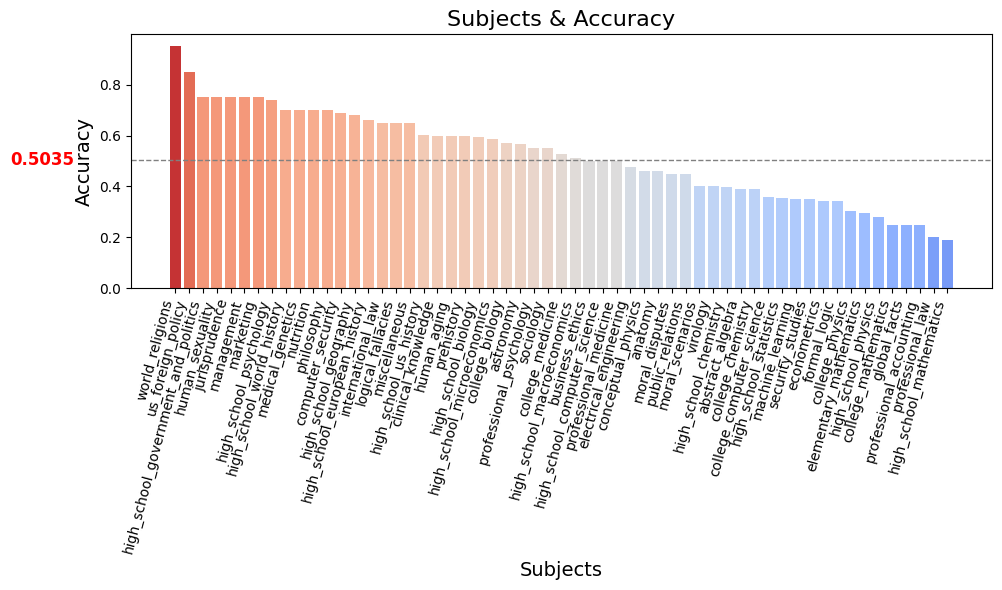

In [126]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 提取横坐标和纵坐标
subjects_lis = [item['subjects'] for item in sorted_result]
acc_lis = [item['acc'] for item in sorted_result]

# 创建颜色映射
cmap = cm.get_cmap('coolwarm')
bar_colors = [cmap(acc) for acc in acc_lis]

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(subjects_lis, acc_lis, color=bar_colors)

# 添加标题和标签
plt.title('Subjects & Accuracy', fontsize=16)
plt.xlabel('Subjects', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=75, ha='right')

# 绘制水平虚线
threshold = weighted_acc
plt.axhline(y=threshold, color='grey', linestyle='--', linewidth=1)

# 在纵轴上标出0.39并加粗
plt.text(-12, threshold, f"{threshold:.4}", color='red', fontsize=12, weight='bold', va='center')

# 显示网格
# plt.grid(axis='y')

# 显示图形
plt.tight_layout()
plt.show()

##  评估模型在每个大类学科的能力

In [86]:
# 评估模型在每个大类学科的能力
from categories import subcategories, categories
# subcategories.items()
sub_cts = []
subs = []
for item in subcategories.items():
#     print(f"{item[0]}: {item[1][0]}")
    sub_cts.append(item[1][0])

In [89]:
sub_cts_dict = {subject: [] for subject in set(sub_cts)}   # 构建sub_cts：subs_list 结构字典

In [91]:
for item in subcategories.items():
    sub_cts_dict[item[1][0]].append(item[0])

In [93]:
# 计算subcategories的评测结果
sub_cts_result = {subject: 0 for subject in set(sub_cts)}    #{"math":[  ,  ,  ,文件名]}

In [109]:
for k in sub_cts_dict.keys():
    result_csv_files = sub_cts_dict[k]
#     print(result_csv_files)
    sub_corrs = []
    for sub in result_csv_files:
        sub_content = pd.read_csv(os.path.join(info.save_dir, f"{info.models[0]}_results", sub+".csv"), header=None)
        sub_corrs.append(sub_content[content.shape[1] - 1].to_list())
    sub_corrs = np.concatenate(sub_corrs)
    sub_weighted_acc = np.mean(sub_corrs)
    sub_cts_result[k] = sub_weighted_acc

In [110]:
sub_cts_result  # 对所有subject_category的评估

{'economics': 0.5107816711590296,
 'politics': 0.7035573122529645,
 'philosophy': 0.4690265486725664,
 'other': 0.30714285714285716,
 'psychology': 0.7309734513274336,
 'chemistry': 0.39603960396039606,
 'computer science': 0.50625,
 'business': 0.5714285714285714,
 'law': 0.5333333333333333,
 'culture': 0.65,
 'history': 0.6308068459657702,
 'geography': 0.6818181818181818,
 'engineering': 0.47586206896551725,
 'physics': 0.4171875,
 'math': 0.2857142857142857,
 'biology': 0.5859030837004405,
 'health': 0.549777117384844}

C:\Users\20931\AppData\Local\Temp\ipykernel_25456\636582300.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


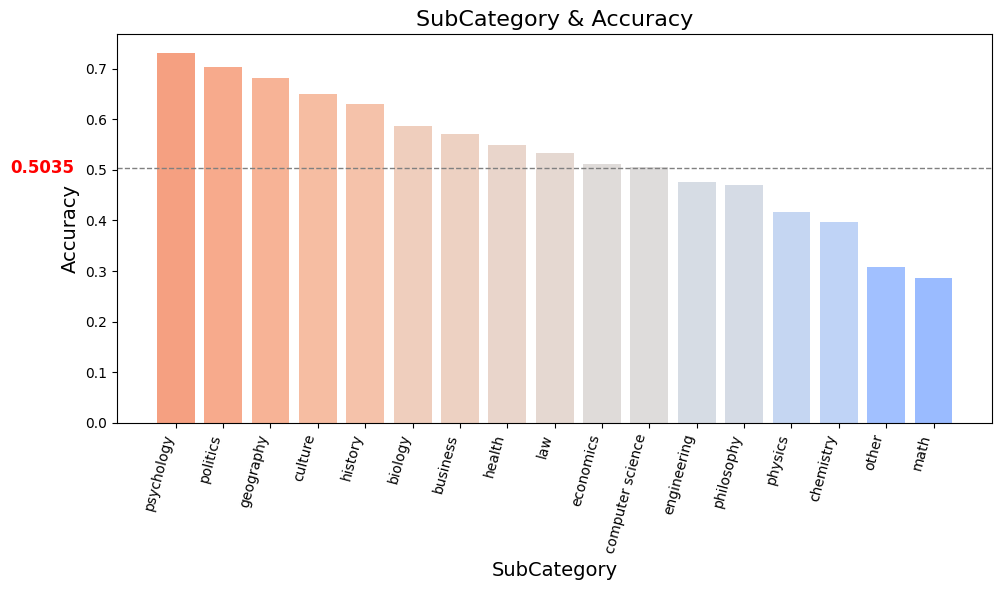

In [133]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sub_cts_result = sorted(sub_cts_result.items(), key=lambda item: item[1], reverse=True)
sub_cts_result = dict(sub_cts_result)

sub_cts_lis = []
sub_cts_eval_lis = []

# 提取横坐标和纵坐标
for item in sub_cts_result.items():
    sub_cts_lis.append(item[0])
    sub_cts_eval_lis.append(item[1])

# 创建颜色映射
cmap = cm.get_cmap('coolwarm')
sub_cts_bar_colors = [cmap(sub_cts_eval) for sub_cts_eval in sub_cts_eval_lis]

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(sub_cts_lis, sub_cts_eval_lis, color=sub_cts_bar_colors)

# 添加标题和标签
plt.title('SubCategory & Accuracy', fontsize=16)
plt.xlabel('SubCategory', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=75, ha='right')

# 绘制水平虚线
threshold = weighted_acc
plt.axhline(y=threshold, color='grey', linestyle='--', linewidth=1)

# 在纵轴上标出0.39并加粗
plt.text(-3.5, threshold, f"{threshold:.4}", color='red', fontsize=12, weight='bold', va='center')

# 显示网格
# plt.grid(axis='y')

# 显示图形
plt.tight_layout()
plt.show()

In [111]:
categories_dict = {cts[0]: [] for cts in categories.items()}

In [113]:
for item in categories.items():   #("STEM",[ "MATH", , ])
    for sub_item in item[1]:
        categories_dict[item[0]].append(sub_cts_dict[sub_item])

In [115]:
for k in categories_dict.keys():
    categories_dict[k] = np.concatenate(categories_dict[k])

In [122]:
# 计算categories评估结果
cts_result = {key: 0 for key in categories_dict.keys()}

In [124]:
for k in categories_dict.keys():
    result_csv_files = categories_dict[k]
#     print(result_csv_files)
    cts_corrs = []
    for sub in result_csv_files:
        sub_content = pd.read_csv(os.path.join(info.save_dir, f"{info.models[0]}_results", sub+".csv"), header=None)
        cts_corrs.append(sub_content[content.shape[1] - 1].to_list())
    cts_corrs = np.concatenate(cts_corrs)
    cts_weighted_acc = np.mean(cts_corrs)
    cts_result[k] = cts_weighted_acc

In [125]:
cts_result

{'STEM': 0.40601503759398494,
 'humanities': 0.5697841726618705,
 'social sciences': 0.6290322580645161,
 'other (business, health, misc.)': 0.5173137460650578}

C:\Users\20931\AppData\Local\Temp\ipykernel_25456\3475915206.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


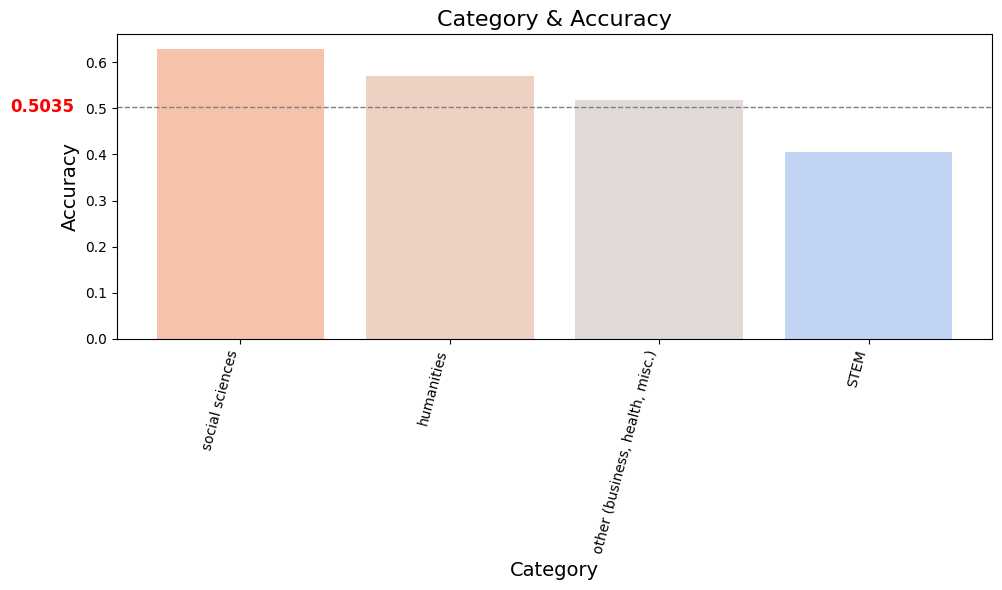

In [138]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cts_result = sorted(cts_result.items(), key=lambda item: item[1], reverse=True)
cts_result = dict(cts_result)

cts_lis = []
cts_eval_lis = []

# 提取横坐标和纵坐标
for item in cts_result.items():
    cts_lis.append(item[0])
    cts_eval_lis.append(item[1])

# 创建颜色映射
cmap = cm.get_cmap('coolwarm')
cts_bar_colors = [cmap(cts_eval) for cts_eval in cts_eval_lis]

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(cts_lis, cts_eval_lis, color=cts_bar_colors)

# 添加标题和标签
plt.title('Category & Accuracy', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=75, ha='right')

# 绘制水平虚线
threshold = weighted_acc
plt.axhline(y=threshold, color='grey', linestyle='--', linewidth=1)

# 在纵轴上标出0.39并加粗
plt.text(-1.1, threshold, f"{threshold:.4}", color='red', fontsize=12, weight='bold', va='center')

# 显示网格
# plt.grid(axis='y')

# 显示图形
plt.tight_layout()
plt.show()

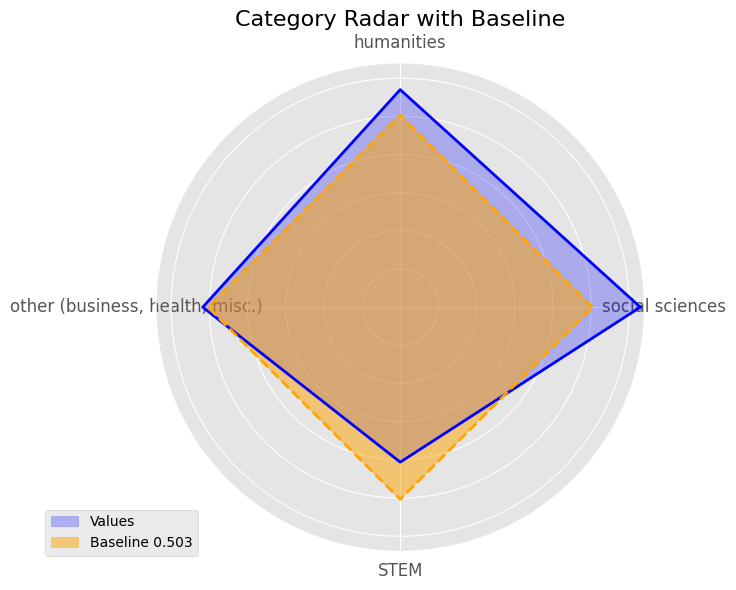

In [156]:
values = cts_eval_lis
features = cts_lis

# 计算每个特征的角度
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()

# 将雷达图的起点与终点连接
values += values[:1]
angles += angles[:1]
baseline = weighted_acc
# 基准线的数据
baseline_values = [baseline] * len(features)
baseline_values += [baseline]  # 闭合基准线

# 绘制雷达图
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

# 绘制数据线
ax.fill(angles, values, color='blue', alpha=0.25, label='Values')
ax.plot(angles, values, color='blue', linewidth=2)

# 绘制基准线
ax.fill(angles, baseline_values, color='orange', alpha=0.5, label=f'Baseline {baseline:.3}')
ax.plot(angles, baseline_values, color='orange', linewidth=2, linestyle='--')

# 添加特征标签
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=12)

# 添加图例
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 添加标题
plt.title('Category Radar with Baseline', fontsize=16)

# 显示图形
plt.tight_layout()
plt.show()